# NueCC selection
Jupyter notebook to look at the outcome of the optical selection, with a focus on electrons

## Imports

In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, clear_output
import pandas as pd

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

## Constants

In [4]:
gr = 1.618
outdir= './output/NueCC/'
inputdir = './input/'  
target = 11
vtx_tolerance = 2

In [5]:
lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]
fidvol_arr = [10,10,10,10,10,50] 

In [6]:
file_name = inputdir+'NueCC_nue_mcc9_nov.root'

## Definitions

In [7]:
def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def textonly(ax, txt, fontsize = 14, loc = 2, *args, **kwargs):
    at = AnchoredText(txt,
                      prop=dict(size=fontsize), 
                      frameon=True,
                      loc=loc)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_arti

## Loading inputs

In [8]:
file_flashid = uproot.open(file_name)['pandoraFlashEventBuilding/events']
file_slices = uproot.open(file_name)['pandoraFlashEventBuilding/slices']
file_nuecc = uproot.open(file_name)['nueCCAnalyser']

In [9]:
nuecc_events = file_nuecc['Event']
nuecc_daughters = file_nuecc['Daughters']

In [10]:
num_events = file_flashid.numentries
num_selected = nuecc_events.numentries
print("Selection efficiency of nueCC without mc fiducial volume")
print("Number of events:", num_events)
print("Number of passed events:", num_selected)
err = np.sqrt(num_selected*(num_events-num_selected)/num_events**3)
print("Selected: ({0:.1f}+-{1:.1f})%".format(num_selected/num_events*100, err*100))

Selection efficiency of nueCC without mc fiducial volume
Number of events: 94800
Number of passed events: 77571
Selected: (81.8+-0.1)%


In [11]:
print("Selection efficiency of nueCC with mc fiducial volume")
flashid_vtx_mc = file_flashid.pandas.df(['nuVertexX', 'nuVertexY', 'nuVertexZ'])
flashid_events_fiducial_mc =  inTPC_df(flashid_vtx_mc, 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol_arr)
num_events_fidvol = sum(flashid_events_fiducial_mc)
print("Number of events:", num_events_fidvol)
nuecc_vtx_mc = nuecc_events.pandas.df(['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz'])
nuecc_events_fiducial_mc =  inTPC_df(nuecc_vtx_mc, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol_arr)
num_selected_fidvol = sum(nuecc_events_fiducial_mc)
print("Number of passed events:", num_selected_fidvol)
err = np.sqrt(num_selected_fidvol*(num_events_fidvol-num_selected_fidvol)/num_events_fidvol**3)
print("Selected: ({0:.1f}+-{1:.1f})%".format(num_selected_fidvol/num_events_fidvol*100, err*100))

Selection efficiency of nueCC with mc fiducial volume
Number of events: 75310
Number of passed events: 65610
Selected: (87.1+-0.1)%


In [30]:
print('--- Availible branches ---')
print('\nfile_flashid:')
print( [key.decode("utf-8") for key in file_flashid.keys()])
print('\nfile_slices:')
print( [key.decode("utf-8") for key in file_slices.keys()])
print('\nnuecc_events:')
print( [key.decode("utf-8") for key in nuecc_events.keys()])
print('\nnuecc_daughters:')
print( [key.decode("utf-8") for key in nuecc_daughters.keys()])

--- Availible branches ---

file_flashid:
['run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'nFlashes', 'nFlashesInBeamWindow', 'hasBeamFlash', 'nSlices', 'nSlicesAfterPrecuts', 'foundATargetSlice', 'targetSliceMethod', 'nuInteractionType', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']

file_slices:
['sliceId', 'run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 'minX', 'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 'xclVariable', 'passesPreCuts', 'flashMatchScore', 'flashMatchX', 'totalPEHypothesis', 'peHypothesisSpectrum', 'isTaggedAsTarget', 'targetMethod', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 'hasBestFlashMatchScore', 'nHits', 'purity', 'completeness', 'isMostComplete', 'nuInteractionType', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuV

In [35]:
occ = np.unique(file_flashid.array("evt_time_nsec"), return_counts=True)
print(len(occ[1]))

192762


In [13]:
# Add columns purity/completeness/targetmethod to the nuecc_events
df_slices = file_slices.pandas.df(['event', 'run', 'subRun', 'nuVertexX', 'isTaggedAsTarget', 'purity', 'completeness','targetMethod']).query('isTaggedAsTarget')
print(len(df_slices))
print("Which method is used to select this event?")
print(df_slices['targetMethod'].value_counts())
print(np.unique(file_flashid.array('targetSliceMethod'), return_counts=True))
hash_slices = eventHash(df_slices[['event', 'run', 'subRun', 'nuVertexX']])
hashmap_purity = dict(zip(hash_slices, df_slices["purity"]))
hashmap_completeness = dict(zip(hash_slices, df_slices["completeness"]))

nuecc_events_hash = eventHash(nuecc_events.pandas.df(['event', 'run', 'subrun', 'mc_nu_vx']))
event_purity = np.array(list(map(hashmap_purity.get, nuecc_events_hash)))
event_completeness = np.array(list(map(hashmap_completeness.get, nuecc_events_hash)))

40908
Which method is used to select this event?
0    32898
1     6683
2     1327
Name: targetMethod, dtype: int64
(array([-1,  0,  1,  2], dtype=int32), array([ 9092, 32898,  6683,  1327]))


In [14]:
# define fiducial vol masks:
mask_mcfv = nuecc_events_fiducial_mc
mask_mcfv_cm = nuecc_events.array(b'mc_nu_vtx_distance')[mask_mcfv]<vtx_tolerance

Percent of selected events with vertex within 2cm: 67.75933465567039


Text(2,800,'Within 2cm: 67.8%')

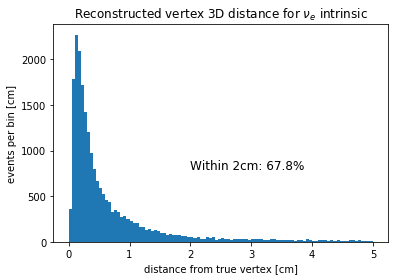

In [15]:
plt.hist(nuecc_events.array('mc_nu_vtx_distance')[(mask_mcfv)], bins=100,range=(0,5))
fraq = sum(mask_mcfv_cm)/num_selected_fidvol*100
print("Percent of selected events with vertex within 2cm:",fraq)
plt.title(r"Reconstructed vertex 3D distance for $\nu_e$ intrinsic")
plt.xlabel('distance from true vertex [cm]')
plt.ylabel('events per bin [cm]')
plt.text(2,800,"Within 2cm: {0:.1f}%".format(fraq), fontsize=12)

In [16]:
mc_daughters = nuecc_events.arrays(["mc_nu_daughter_matched", "mc_nu_daughter_pdg", "mc_nu_daughter_energy"])
#mc_daughters[b'mc_nu_daughter_pdg'].pandas()
#print(len(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv])

# how  many of the events have an electron daughter?
print('Number of electrons per selected event')
electron_mask = (abs(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv])==target)
electron_count = electron_mask.sum()
print(np.unique(electron_count, return_counts=True))

# how many have a reconstructed electron:
print('Number of reconstructed electrons per selected event')
electron_reco_mask = (abs(mc_daughters[b'mc_nu_daughter_pdg'][mask_mcfv]*mc_daughters[b'mc_nu_daughter_matched'][mask_mcfv])==target)
electron_reco_count = electron_reco_mask.sum()
print(np.unique(electron_reco_count, return_counts=True))

Number of electrons per selected event
(array([1, 3]), array([28734,     3]))
Number of reconstructed electrons per selected event
(array([0, 1, 2]), array([ 2514, 26220,     3]))


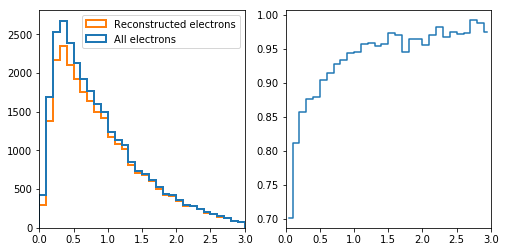

In [17]:
electron_energy_reco = mc_daughters[b'mc_nu_daughter_energy'][mask_mcfv][electron_reco_mask].content
electron_energy_all = mc_daughters[b'mc_nu_daughter_energy'][mask_mcfv][electron_mask].content

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4), sharex=True, sharey=False)

bins, edges, _ = ax[0].hist([electron_energy_all,electron_energy_reco], histtype='step', lw=2, 
                            label = ['All electrons', 'Reconstructed electrons'], range=(0,3), bins=30 )
ax[0].legend()
ax[0].set_xlim(0,3)
ax[1].step((edges[:-1]+edges[1:])/2,bins[1]/bins[0], where='mid')

In [18]:
mask_mcfv_pure = nuecc_events.array('cosmic_matched')[mask_mcfv]
# Mask means that the true vertex was within the fiducial volume, is reconstructed within 1cm and no daughters are cosmic matched
mask_mc_ok = ~mask_mcfv_pure & mask_mcfv_cm
print(len(mask_mc_ok))
print(sum(mask_mc_ok))
print('Fraction of events with reconstructed vertex within 2cm and all daughters are neutrino matched: ', sum(mask_mc_ok)/len(mask_mc_ok))

28737
17178
Fraction of events with reconstructed vertex within 2cm and all daughters are neutrino matched:  0.5977659463409541


In [19]:
# Aantal events met dochter(s) die geen match hadden, ondanks dat de dochter opgeslagen is.
unmatched_daughters = nuecc_events.array(b'num_daughters')-nuecc_events.array(b'num_matched_daughters')
sum((unmatched_daughters==0)*1-1*nuecc_events.array(b'daughters_stored'))

-170

## Reconstructed daughters 

In [20]:
hash_events = eventHash(nuecc_events.pandas.df(['event', 'run', 'subrun', 'numpfp']))
hash_fidvol = dictionary = dict(zip(hash_events, mask_mcfv))
hash_purity = dictionary = dict(zip(hash_events, event_purity))
hash_completeness = dictionary = dict(zip(hash_events, event_completeness))

In [21]:
df_daughters = nuecc_daughters.pandas.df()
df_daughters['broken_pfp'] = df_daughters.duplicated(subset=['mc_energy', 'mc_vx', 'mc_vy', 'mc_vz'], keep=False)

df_daughters['event_hash'] = eventHash(df_daughters[['event', 'run', 'subrun', 'numpfp']])
df_daughters['mc_nu_fidvol'] = df_daughters['event_hash'].map(hash_fidvol)
df_daughters['mc_nu_purity'] = df_daughters['event_hash'].map(hash_purity)
df_daughters['mc_nu_completeness'] = df_daughters['event_hash'].map(hash_completeness)

df_daughters['hitsTotal'] = df_daughters.eval('hitsU+hitsV+hitsY')
df_daughters['vtx_distance'] = df_daughters.eval('sqrt( (vx-mc_vx_sce)**2 + (vy-mc_vy_sce)**2 + (vy-mc_vy_sce)**2 )')
df_daughters['nr_clusters'] = df_daughters.eval('1*(hitsU>0)+1*(hitsV>0)+1*(hitsY>0)')

In [22]:
df_daughters.head(15)

,event,run,subrun,numpfp,hitsU,hitsV,hitsY,hitsSps,generation,track_score,is_shower,is_track,has_shower_daughter,is_track_daughter,vx,vy,vz,mc_neutrino,mc_vx,mc_vy,mc_vz,mc_vx_sce,mc_vy_sce,mc_vz_sce,mc_energy,mc_pdg,broken_pfp,event_hash,mc_nu_fidvol,mc_nu_purity,mc_nu_completeness,hitsTotal,vtx_distance,nr_clusters
0,7241,1,363,55,286,180,135,326,2,0.012729,True,False,False,False,114.362778,74.408958,682.700012,True,113.266434,78.718185,681.858459,113.985619,75.448982,681.800354,0.415744,-11,False,-4598223148685192183,True,0.998415,0.882353,601,1.518403,3
1,7242,1,363,159,100,146,102,184,2,0.017612,True,False,False,False,115.313339,75.967796,65.399994,True,113.747551,77.901520,64.211365,115.177208,75.926460,65.303848,0.376883,-11,False,-2506350657229642160,True,0.984340,0.695103,348,0.148152,3
2,7244,1,363,109,139,147,292,568,2,0.999792,False,True,False,False,214.712921,-67.887337,450.225861,True,212.594162,-75.922905,450.300720,214.608383,-67.932251,450.337646,1.421784,2212,False,-4614169359416453264,True,0.977644,0.823913,578,0.122322,3
3,7244,1,363,109,198,77,260,460,2,0.243117,True,False,False,False,215.166702,-67.965630,450.899994,True,212.594162,-75.922905,450.300720,214.608383,-67.932251,450.337646,1.004651,11,False,-4614169359416453264,True,0.977644,0.823913,535,0.560311,3
4,7246,1,363,97,68,44,101,161,2,0.509550,False,True,False,False,232.428802,-97.059761,570.151550,True,229.240021,-112.344292,570.030457,232.422180,-97.529228,569.935486,0.996881,11,False,-6721302013775578518,False,1.000000,0.935223,213,0.663960,3
5,7246,1,363,97,6,8,0,10,2,0.830602,False,True,False,False,232.367340,-97.010727,569.940857,True,229.240021,-112.344292,570.030457,232.422180,-97.529228,569.935486,0.992004,2212,False,-6721302013775578518,False,1.000000,0.935223,14,0.735319,2
6,7247,1,363,126,155,177,264,542,2,0.022188,True,False,False,False,235.313110,68.693192,840.799988,True,192.409378,71.431198,748.084106,193.588760,64.816399,748.010681,0.935776,11,True,7524285747173791046,True,0.975936,0.502063,596,42.083019,3
7,7247,1,363,126,17,16,41,58,2,0.874955,False,True,False,False,225.353134,79.831970,858.478699,True,192.409378,71.431198,748.084106,193.588760,64.816399,748.010681,0.935776,11,True,7524285747173791046,True,0.975936,0.502063,74,38.208771,3
8,7248,1,363,73,425,279,397,939,2,0.011430,True,False,False,False,69.058434,18.810135,990.000000,True,67.982193,19.197666,990.693787,68.994911,19.089861,989.822327,0.527215,11,False,8034591694561328160,False,0.908525,0.983921,1101,0.400660,3
9,7248,1,363,73,11,108,107,200,2,0.845241,False,True,True,False,69.188858,20.041939,991.368713,True,67.982193,19.197666,990.693787,68.994911,19.089861,989.822327,0.750110,211,True,8034591694561328160,False,0.908525,0.983921,226,1.360338,3


In [23]:
str_query1 = 'abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol'
str_query2 = 'abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol & ~broken_pfp'
str_query3 = 'abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol & vtx_distance<@vtx_tolerance'

lab_query = [r'$\nu_e$ Electron matched', 'Not broken', 'Vtx distance < '+str(vtx_tolerance)+'cm']

In [24]:
# one pfp per event max
df_target_electrons = df_daughters.query('abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol').drop_duplicates(subset=['mc_pdg', 'mc_energy', 'mc_energy', 'mc_vx', 'mc_vy', 'mc_vz'])
# Energy of all reconstructed electrons
matched_electron_energy = df_target_electrons['mc_energy']
print('Number of events:', num_selected_fidvol )
print("All reconstructed electron matched pfp:", len(df_daughters.query('abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol')))
print("Events with at least one electron matched pfp:", len(matched_electron_energy))
print("Events with exactly one electron matched pfp:", sum(1==df_daughters.query('abs(mc_pdg)==@target & mc_neutrino & mc_nu_fidvol').groupby(['mc_pdg', 'mc_energy', 'mc_energy', 'mc_vx', 'mc_vy', 'mc_vz']).size()))
print("Events with at least one electron matched pfp within 2cm:", len(df_daughters.query('mc_pdg==@target & mc_neutrino & vtx_distance<@vtx_tolerance').drop_duplicates(subset=['mc_pdg', 'mc_energy', 'mc_energy', 'mc_vx', 'mc_vy', 'mc_vz'])))

Number of events: 28737
All reconstructed electron matched pfp: 40710
Events with at least one electron matched pfp: 26240
Events with exactly one electron matched pfp: 16716
Events with at least one electron matched pfp within 2cm: 18766


Percent of selected events with vertex within 2cm: 65.30257159759195


Text(2,800,'Within 2cm: 65.3%')

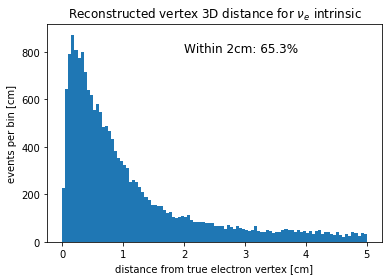

In [25]:
plt.hist(df_target_electrons['vtx_distance'], bins=100,range=(0,5))
fraq = len(df_daughters.query('mc_pdg==@target & mc_neutrino & vtx_distance<@vtx_tolerance').drop_duplicates(subset=['mc_pdg', 'mc_energy', 'mc_energy', 'mc_vx', 'mc_vy', 'mc_vz']))/num_selected_fidvol*100
print("Percent of selected events with vertex within 2cm:",fraq)
plt.title(r"Reconstructed vertex 3D distance for $\nu_e$ intrinsic")
plt.xlabel('distance from true electron vertex [cm]')
plt.ylabel('events per bin [cm]')
plt.text(2,800,"Within 2cm: {0:.1f}%".format(fraq), fontsize=12)

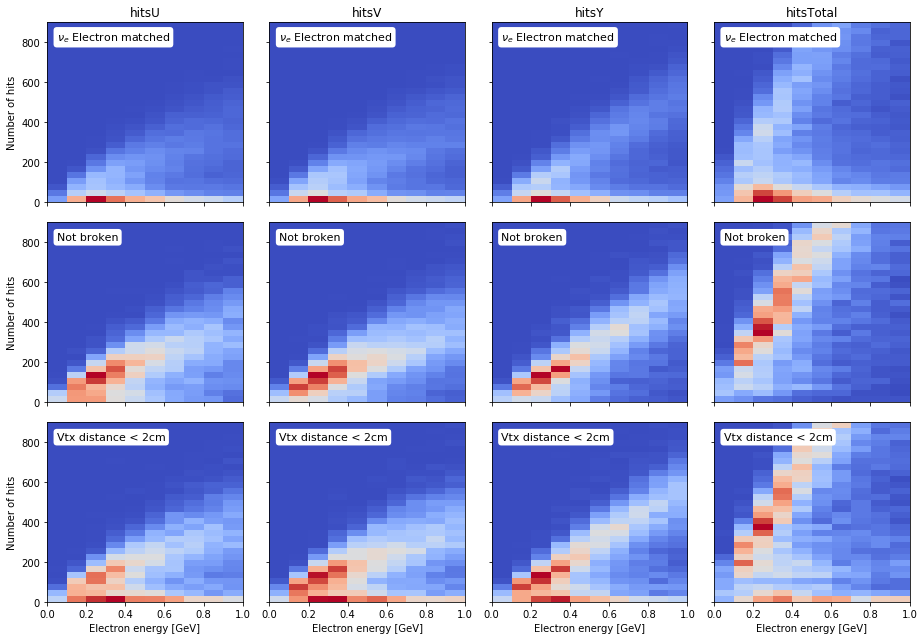

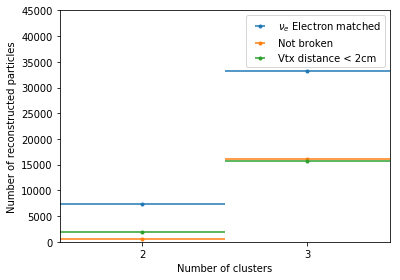

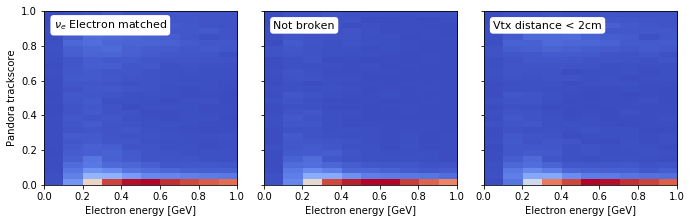

In [26]:
# number of hits in function of the energy on U,V,Y planes (all electron matched daughters / non-broken electrons):
fig,ax = plt.subplots(ncols=4,nrows=3,figsize=(8*gr,9), sharex=True, sharey=True)
fig2,ax2 = plt.subplots(ncols=1,nrows=1,figsize=(3.5*gr,4))
fig3,ax3 = plt.subplots(ncols=3,nrows=1,figsize=(6*gr,3.2), sharex=True, sharey=True)

x_max = 1
y_max = 900

for j,(query,lab) in enumerate(zip([str_query1, str_query2, str_query3],lab_query)):
    ax[j][0].set_ylabel('Number of hits')
    df_view = df_daughters.query(query)
    
    steps,_ = np.histogram(df_view['nr_clusters'],range=(1.5,3.5),bins=2)
    ax2.errorbar([2,3], steps, xerr=[0.5]*2, fmt='.',label=lab)
    ax3[j].hist2d(df_view['mc_energy'], df_view['track_score'], bins=(10,30), cmap='coolwarm', range=((0,x_max),(0,1)))
    ax3[j].annotate(lab,
                    xy=(0.05,0.9), xycoords='axes fraction',
                    size=11,
                    bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none"))
    ax3[j].set_xlabel("Electron energy [GeV]")
    
    for i,plane in enumerate(['hitsU', 'hitsV', 'hitsY', 'hitsTotal']):
        #ax[j][i].scatter(df_view['mc_energy'], df_view[plane], alpha=0.1, s=1.5)
        ax[j][i].hist2d(df_view['mc_energy'], df_view[plane], bins=(10,30), cmap='coolwarm', range=((0,x_max),(0,y_max)))
        
        ax[j][i].annotate(lab,
            xy=(0.05,0.9), xycoords='axes fraction',
            size=11,
            bbox=dict(boxstyle="round", fc=(1.0, 1.0, 1.0), ec="none"))
        
for i,plane in enumerate(['hitsU', 'hitsV', 'hitsY', 'hitsTotal']):
    ax[0][i].set_title(plane)
    ax[2][i].set_xlabel("Electron energy [GeV]")
    
ax[0][0].set_xlim(0,x_max)
ax[0][0].set_ylim(0,y_max)

ax2.set_xticks([2,3])
ax2.set_xlim(1.5,3.5)
ax2.set_ylim(0,45000)
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Number of reconstructed particles')
ax2.legend()

ax3[0].set_ylabel('Pandora trackscore')

fig.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

uint32


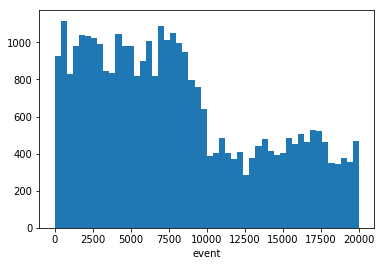

uint32


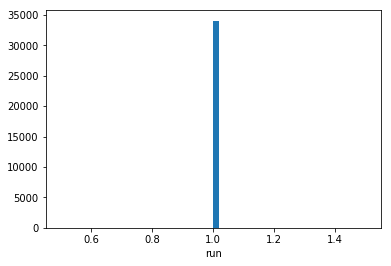

uint32


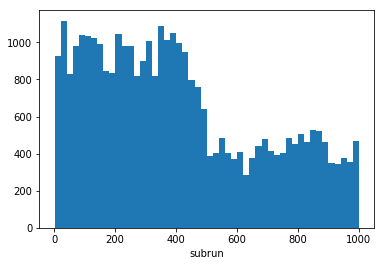

uint32


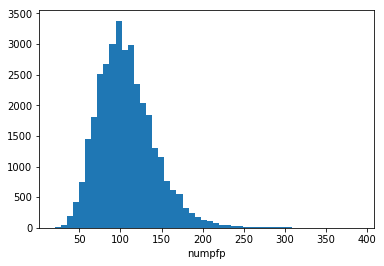

uint32


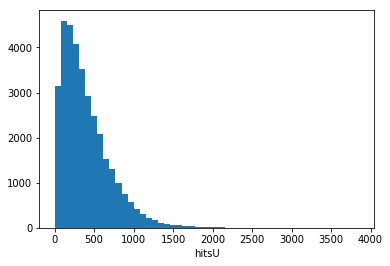

uint32


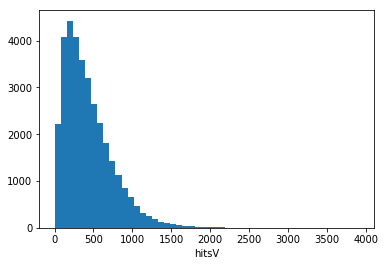

uint32


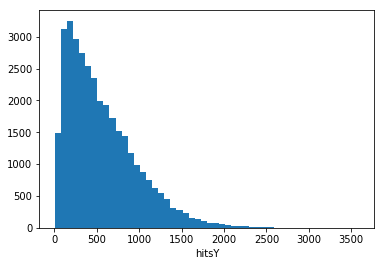

uint32


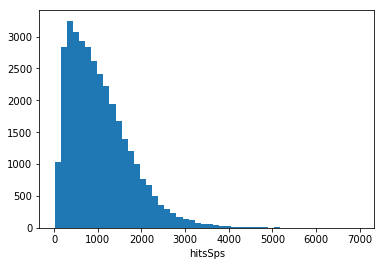

uint32


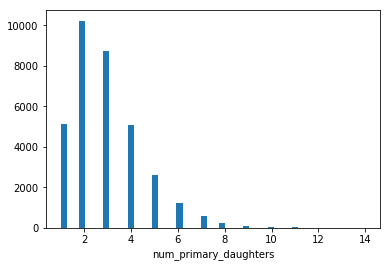

uint32


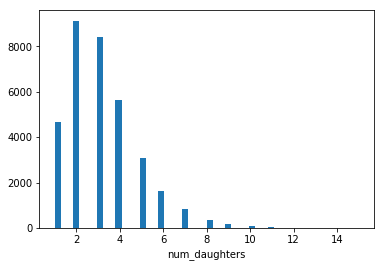

uint32


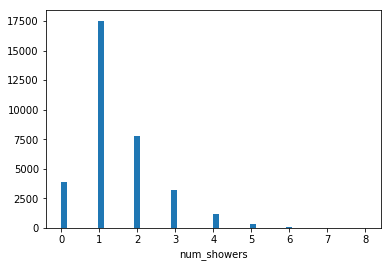

uint32


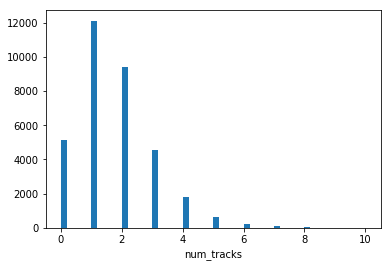

bool


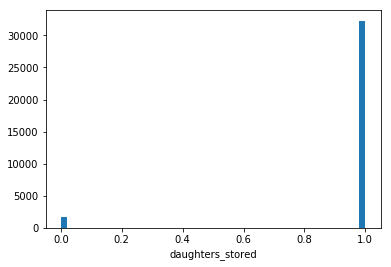

float32


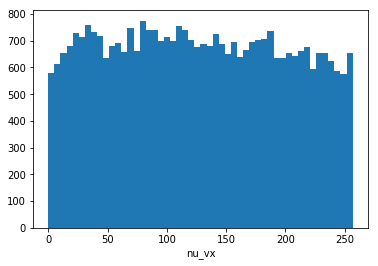

float32


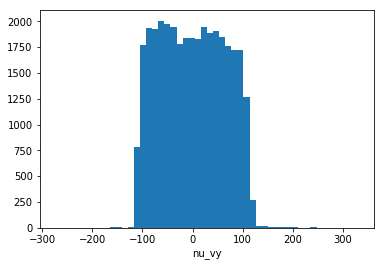

float32


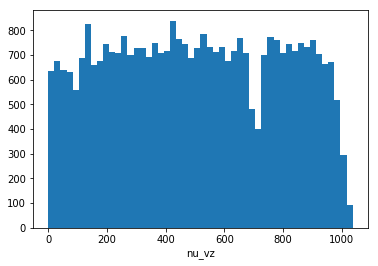

int32


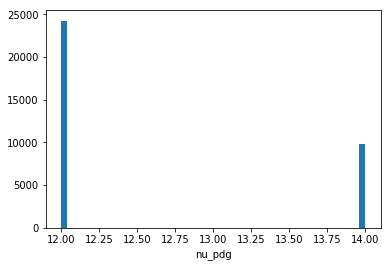

uint32


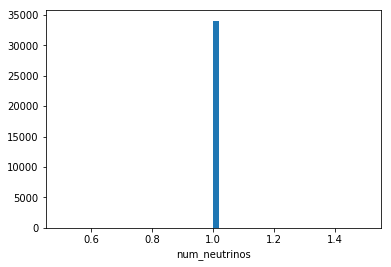

float32


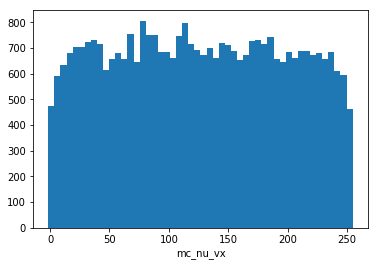

float32


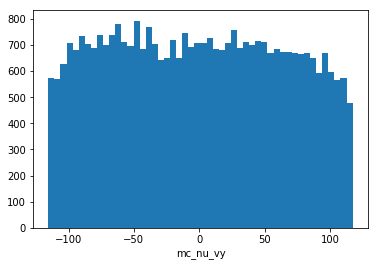

float32


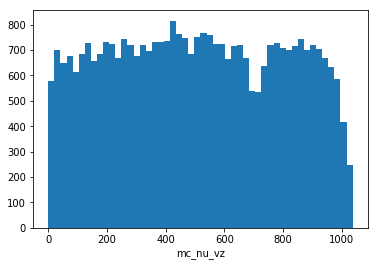

float32


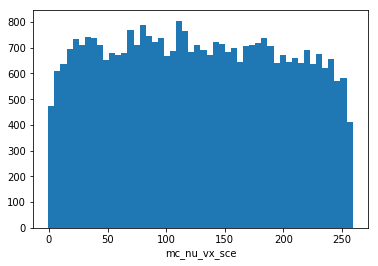

float32


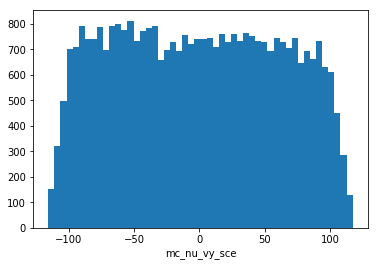

float32


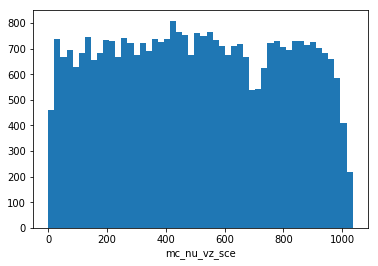

float32


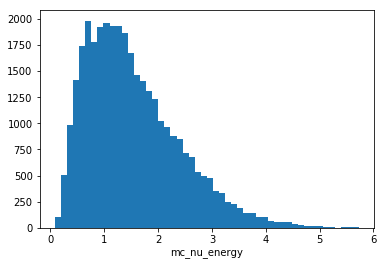

float32


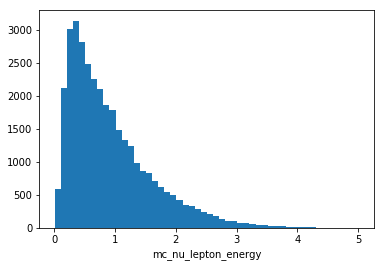

float32


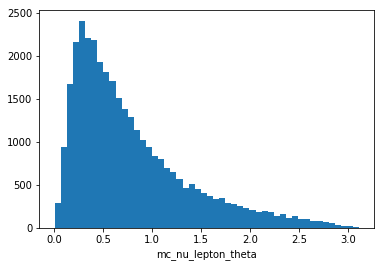

float32


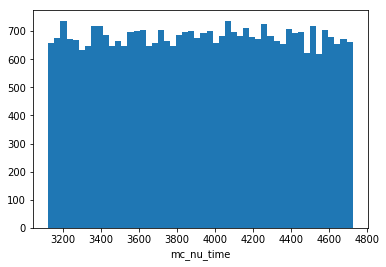

int32


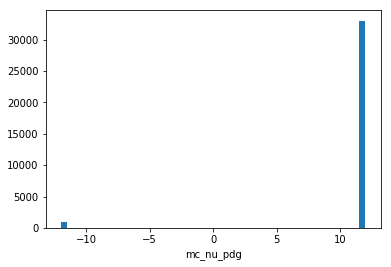

int32


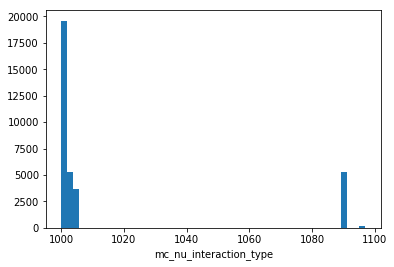

bool


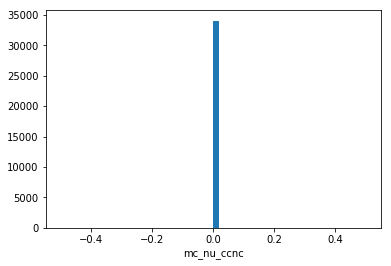

float32


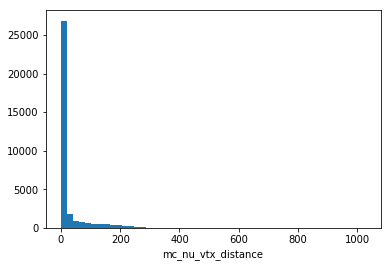

uint32


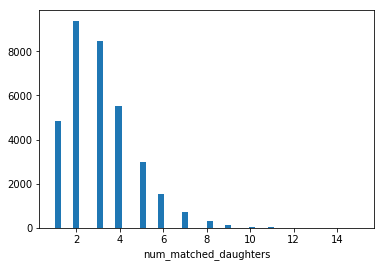

bool


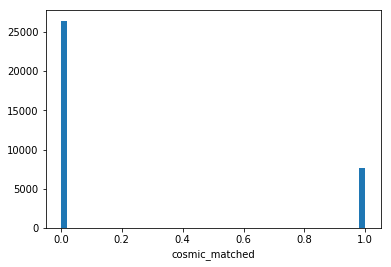

object
object
object


In [27]:
for key in nuecc_events.keys():
    field = nuecc_events.array(key)
    print(field.dtype)
    if field.dtype == np.bool:
        field = 1*field
    if field.dtype == object:
        continue
    plt.hist(field, bins=50)
    plt.xlabel(key.decode("utf-8"))
    plt.show()